# pyGMs Introduction: Learning from Data

In [1]:
import numpy as np
import pyGMs as gm
import matplotlib.pyplot as plt

... data, likelihood, model fitting, etc. ...

### <span style="color:red"> TODO: lots </span>

## Assessing Model Fit

Let us use the Alarm Bayesian network to illustrate data likelihood:

In [3]:
B = gm.Var(0,2)   # Was there a burglary at Sherlock Holmes' house?
E = gm.Var(1,2)   # Was there an earthquake?
A = gm.Var(2,2)   # Has the alarm gone off?
W = gm.Var(3,2)   # Has Watson called to complain?
H = gm.Var(4,2)   # Has Mrs Hudson called to complain?

X = [B,E,A,W,H]   # we'll often refer to variables as Xi or X[i]

names = dict( (eval(n).label,n) for n in ['B','E','A','W','H'])

p_E = gm.Factor([E], [.998, .002]) # probability of earthquake (false,true)
p_B = gm.Factor([B], [.999, .001]) # probability of burglary
p_A_BE = gm.Factor([A,B,E], 0.0)   # alarm given B,E
# Set  B,E,A                       # 
p_A_BE[0,0,:] = [.999, .001]       # 
p_A_BE[0,1,:] = [.710, .290]       
p_A_BE[1,0,:] = [.060, .940]       # For each setting (b,e), the table should sum to one over A
p_A_BE[1,1,:] = [.050, .950]       #   so that it corresponds to a conditional probability

p_W_A = gm.Factor([A,W], 0.0)      # Probability that Watson calls given the alarm's status
p_W_A[0,:]    = [.95, .05]
p_W_A[1,:]    = [.10, .90]

p_H_A = gm.Factor([A,H], 0.0)      # Probability that Mrs Hudson calls given the alarm's status
p_H_A[0,:]    = [.99, .01]
p_H_A[1,:]    = [.30, .70]

factors = [p_W_A, p_H_A, p_A_BE, p_E, p_B]  # collect all the factors that define the model

model = gm.GraphModel([p_E,p_B,p_A_BE,p_W_A,p_H_A])

### Data Likelihood

Suppose that we observe some data, $D$:

In [14]:
D = [(0, 0, 0, 1, 1), (1, 1, 0, 1, 0), (1, 1, 0, 1, 1), (1, 0, 0, 1, 0), (0, 1, 1, 1, 1), 
     (0, 1, 1, 1, 0), (0, 1, 0, 1, 1), (0, 0, 1, 1, 1), (1, 0, 1, 1, 0), (1, 0, 0, 1, 1)]

How likely is this data under our model?  Since our model is normalized, we can compute the log likelihood of each point, $\log p(x)$, by just evaluating the model at $x$:

In [15]:
LL = [model.logValue(x) for x in D]
print(LL)
print()
print(f'Average log-likeliood of D: {np.mean(LL)}')

[array([-7.60490546]), array([-19.12387826]), array([-23.71899811]), array([-12.72895061]), array([-7.91551841]), array([-8.76281627]), array([-14.15900137]), array([-7.37279324]), array([-8.28096601]), array([-17.32407046])]

Average log-likeliood of D: -12.699189820279875


But what if our model is not normalized?  In that case, we need both $\log f(x)$, the evaluation of our model at $x$, and also the normalizing constant (or partition function), $Z$:

In [18]:
model_W = model.copy()
model_W.condition({W:1})  # model given that we know Watson called

elim = model_W.copy()
elim.eliminate(X, 'sum')
lnZ = elim.logValue([])

LL = [model_W.logValue(x) - lnZ for x in D]
print(LL)
print()
print(f'Average log-likeliood of D given W=1: {np.mean(LL)}')

[array([-4.65106295]), array([-16.17003574]), array([-20.76515559]), array([-9.77510809]), array([-4.9616759]), array([-5.80897376]), array([-11.20515885]), array([-4.41895073]), array([-5.32712349]), array([-14.37022794])]

Average log-likeliood of D given W=1: -9.745347304424087


The helper function `loglikelihood` can perform this calculation for you, either calculating log Z, or using a known value if optionally passed:

In [26]:
LL = gm.loglikelihood(model_W,D)   # pass "logZ=lnZ" if lnZ is already calculated
print(LL)

[[ -4.65106295]
 [-16.17003574]
 [-20.76515559]
 [ -9.77510809]
 [ -4.9616759 ]
 [ -5.80897376]
 [-11.20515885]
 [ -4.41895073]
 [ -5.32712349]
 [-14.37022794]]


### Pseudo-likelihood

Unfortunately, a major complication of using log-likelihood for scoring models is the requirement of calculating the log partition function, which can be computationally difficult.  The computationally simpler "pseudo-likelihood" is sometimes used in its place:

In [27]:
PLL = gm.pseudologlikelihood(model_W,np.array(D))
print(PLL)

[ -5.4225763  -20.61720497 -30.64518144 -14.19056285  -1.36277531
  -2.57890251 -17.40618398  -2.06181856  -1.94167805 -24.21651688]


While not the same as likelihood, the pseudolikelihood can be used to assess relative fit or guide a learning process.  We can see that in our example samples, the log-likelihood and pseudo-loglikelihood are correlated, with data points exhibiting either relatively lower values or higher values for both:

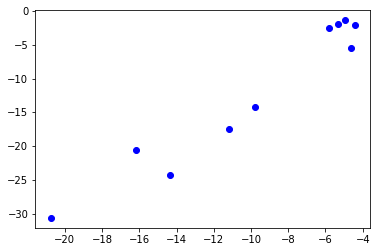

In [32]:
plt.plot(LL,PLL,'b.',ms=12);

## Fitting a Model to Data

Divide into two cases:
* Where the model structure and parameters are unknown
* Where the parameters are unknown, but the model structure is known

In [63]:
D = [(1, 0, 1, 1, 0), (0, 1, 0, 1, 1), (0, 1, 1, 0, 1), (1, 1, 1, 1, 0), (0, 1, 1, 1, 1), 
     (1, 1, 1, 1, 0), (1, 1, 1, 1, 0), (0, 1, 1, 1, 0), (0, 1, 1, 0, 0), (1, 0, 1, 0, 1)]

### Chow-Liu Trees
We can efficiently find both the tree structure and parameters that maximize the likelihood of our data over all tree-structured graphs using an algorithm known as Chow-Liu:

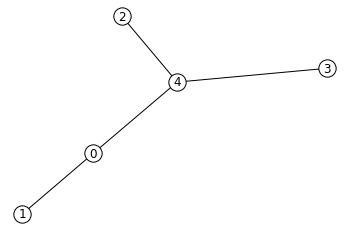

In [64]:
model_cl = gm.fit_chowliu(np.array(D))

fig,ax=plt.subplots(1,1); ax.set_axis_off();
gm.drawMarkovGraph(model_cl,node_color='w');

The function can add a BIC complexity penalty allowing it to select a forest, i.e., select fewer edges when they do not improve the log likelihood sufficiently.  Data can also be given weights, for example data from importance sampling, or weighted data during expectation-maximization learning.

Fit methods
* Chow Liu
* BN Brute Force
* ILP optimization
* Group-L1-penalized PLL
* Independence tests
* Greedy?

Refit methods
* PLL (sgd; scipy.opt)
* Gradient (estimator?)
  * JT/MC/MCMC/Decomp/Var - work per gradient step?
* IPF
  * Infer method? VE/JT/etc
  * "full fit" vs fixed point update (gradient like?)
